In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.0 MB/s eta 0:00:00


In [ ]:
import pydicom
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
dicom_file_path = '/content/drive/MyDrive/Pancreas-CT 20200910.tcia'
dicom_data = pydicom.dcmread(dicom_file_path, force=True)

In [ ]:
import nibabel as nib
import numpy as np
import scipy.ndimage

# Function to load and resize NIfTI data using resampling
def load_and_resize_nii(file_path, target_shape):
    # Load the NIfTI file
    label_data = nib.load(file_path)

    # Get the label data as a NumPy array
    label_array = label_data.get_fdata()

    # Calculate scaling factors for resizing
    scaling_factors = [
        target_shape[0] / label_array.shape[0],
        target_shape[1] / label_array.shape[1],
        target_shape[2] / label_array.shape[2]
    ]

    # Resize the data using resampling
    resized_label_array = scipy.ndimage.zoom(label_array, scaling_factors, order=1)

    return resized_label_array

# Directory containing your NIfTI label files
label_dir_path = "/content/drive/MyDrive/TCIA_pancreas/TCIA_labels"

# Directory where you want to save the resized NIfTI data
output_dir = "/content/drive/MyDrive/TCIA_pancreas/Resized_Labels"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Target shape for resizing (adjust to your desired shape)
target_shape = (64, 64, 64)  # Adjust as needed

# List all NIfTI label files in the directory
label_files = [os.path.join(label_dir_path, file) for file in os.listdir(label_dir_path) if file.endswith(".nii.gz")]

# Process and resize each NIfTI label file
for label_file_path in label_files:
    # Load and resize the NIfTI label data
    resized_label_array = load_and_resize_nii(label_file_path, target_shape)

    # Define the affine matrix for the new image
    # You can use the affine from the original label_data or create a new one as needed
    new_affine = np.eye(4)  # Replace with the appropriate affine transformation if needed

    # Create a new NIfTI file with the resized data and the defined affine matrix
    output_file_path = os.path.join(output_dir, os.path.basename(label_file_path))
    resized_label_img = nib.Nifti1Image(resized_label_array, affine=new_affine)

    # Save the resized NIfTI file
    nib.save(resized_label_img, output_file_path)

    # Print information about the resizing
    print(f"Resized and saved: {output_file_path}")


Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0021.nii.gz
Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0005.nii.gz
Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0008.nii.gz
Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0012.nii.gz
Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0016.nii.gz
Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0032.nii.gz
Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0015.nii.gz
Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0019.nii.gz
Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0038.nii.gz
Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0023.nii.gz
Resized and saved: /content/drive/MyDrive/TCIA_pancreas/Resized_Labels/label0009.nii.gz
Resized and saved: /content/driv

In [ ]:
import nibabel as nib
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Directory containing your NIfTI files
data_dir = "/content/drive/MyDrive/TCIA_pancreas/Resized_Labels"

# List all NIfTI files in the directory
nii_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(".nii.gz")]

# Load and preprocess NIfTI data
data_list = []
for nii_file in nii_files:
    # Load the NIfTI file
    nii_data = nib.load(nii_file)

    # Get the NIfTI data as a NumPy array
    nii_array = nii_data.get_fdata()

    # Flatten the 3D data into a 1D vector
    flattened_data = nii_array.flatten()

    # Append the flattened data to the list
    data_list.append(flattened_data)

# Convert the list of flattened data to a NumPy array
data_matrix = np.array(data_list)

# Perform dimensionality reduction using PCA
num_components = 50  # Adjust the number of components as needed
pca = PCA(n_components=num_components)
reduced_data = pca.fit_transform(data_matrix)

# Perform clustering using K-Means
num_clusters = 3  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(reduced_data)

# Now, 'cluster_labels' contains the cluster assignments for each NIfTI file
# You can further analyze or visualize the clusters as needed.


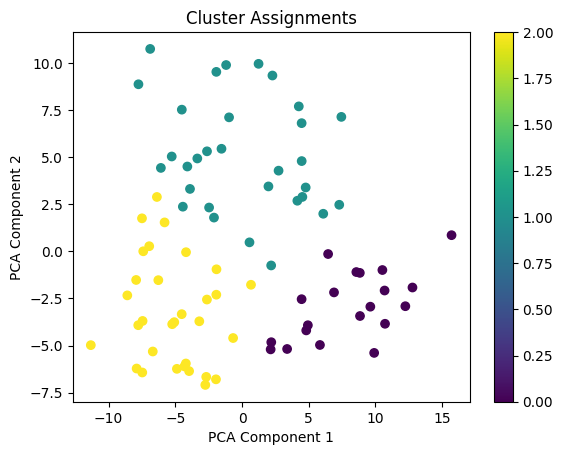

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming reduced_data contains the reduced data after PCA
# cluster_labels contains cluster assignments
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Cluster Assignments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


In [ ]:
cluster_statistics = []
for cluster_id in range(num_clusters):
    cluster_data = reduced_data[cluster_labels == cluster_id]
    cluster_mean = np.mean(cluster_data, axis=0)
    cluster_median = np.median(cluster_data, axis=0)
    cluster_std = np.std(cluster_data, axis=0)
    cluster_statistics.append({
        'Cluster': cluster_id,
        'Mean': cluster_mean,
        'Median': cluster_median,
        'Standard Deviation': cluster_std
    })
print(cluster_statistics)

[{'Cluster': 0, 'Mean': array([ 7.97699977e+00, -2.90365008e+00, -3.63971200e-01,  1.65057066e+00,
        9.19261740e-01, -8.70084740e-01,  3.40016099e-01,  7.90864907e-01,
        3.15777328e-01,  7.32616610e-01,  2.63714500e-01, -2.90415702e-02,
        6.68951125e-01,  1.16629783e-01, -9.38186178e-02, -2.11050539e-01,
        1.09257541e-01, -2.46853365e-01,  4.16340839e-01, -2.01921901e-01,
        7.20849502e-03, -1.98088343e-01, -8.82555247e-02, -2.49186934e-01,
        3.85552679e-02,  1.51875253e-01, -3.26677477e-01, -3.54046310e-01,
        5.93760809e-02,  3.31175908e-01,  8.05326859e-02, -1.02553862e-01,
       -2.33838114e-01, -1.64867139e-02, -2.82891321e-01, -7.78158433e-02,
        3.92930054e-02,  1.38047244e-01,  4.12452866e-02, -1.33848006e-03,
        1.19079572e-01, -1.19975230e-01, -8.91603178e-02, -1.17569591e-01,
        1.03771794e-01, -6.69981963e-02, -2.99257009e-02,  1.70436940e-01,
       -7.19237884e-02, -2.89224720e-02]), 'Median': array([ 8.69988418e+00,

In [ ]:
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom

def preprocess_nii_data(nii_data, target_shape):
    # Get the NIfTI data as a NumPy array
    nii_array = nii_data.get_fdata()

    # Compute scaling factors for resizing
    scaling_factors = (
        target_shape[0] / nii_array.shape[0],
        target_shape[1] / nii_array.shape[1],
        target_shape[2] / nii_array.shape[2]
    )

    # Resize the NIfTI data to the target shape using zoom
    preprocessed_data = zoom(nii_array, scaling_factors, order=3)  # Using cubic interpolation (order=3)

    # Normalize the data to the range [0, 1]
    preprocessed_data = preprocessed_data / np.max(preprocessed_data)

    return preprocessed_data


In [ ]:
def extract_label(file_path):
    # Extract the label from the file name (modify this based on your file naming convention)
    file_name = os.path.basename(file_path)
    label = file_name.split('.')[0].replace('label', '')  # Extract XYZ from labelXYZ
    return int(label)

In [ ]:
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split


# List all NIfTI files in the directory
nii_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(".nii.gz")]

# Load and preprocess NIfTI data, and create labels or cluster assignments
data_list = []
labels = []  # Create a list to store labels or cluster assignments

for nii_file in nii_files:
    # Load and preprocess the NIfTI file (replace with your preprocessing logic)
    nii_data = nib.load(nii_file)
    target_shape = (64, 64, 64)  # Specify the desired target shape
    preprocessed_data = preprocess_nii_data(nii_data, target_shape)
    # Extract label or cluster assignment based on your problem
    label = extract_label(nii_file)  # Replace with your label extraction logic

    data_list.append(preprocessed_data)
    labels.append(label)

# Convert the list of preprocessed data and labels to NumPy arrays
X = np.array(data_list)
y = np.array(labels)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
!pip install git+https://github.com/zhixuhao/unet.git


  Cloning https://github.com/zhixuhao/unet.git to /tmp/pip-req-build-g7xfnenj
  Running command git clone --filter=blob:none --quiet https://github.com/zhixuhao/unet.git /tmp/pip-req-build-g7xfnenj
  Resolved https://github.com/zhixuhao/unet.git to commit b45af4d458437d8281cc218a07fd4380818ece4a
ERROR: git+https://github.com/zhixuhao/unet.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the U-Net model
def unet_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output
    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(conv5)

    model = keras.Model(inputs, outputs)
    return model

# Create the U-Net model
model = unet_model()

# Compile the model (you may need to adjust the loss and metrics depending on your task)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
!pip install unet


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Define input shape and number of classes (adjust accordingly)
input_shape = (64, 64, 64, 3)  # Update this to match your data
num_classes = 2

# Define your U-Net model
def unet_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    # Define the encoding path
    conv1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling3D((2, 2, 2))(conv1)
    conv2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling3D((2, 2, 2))(conv2)

    # Define the middle layer
    conv3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)

    # Define the decoding path
    up4 = layers.UpSampling3D((2, 2, 2))(conv3)
    up4 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up4)
    merge4 = layers.concatenate([conv2, up4], axis=-1)
    conv4 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(merge4)

    up5 = layers.UpSampling3D((2, 2, 2))(conv4)
    up5 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv1, up5], axis=-1)
    conv5 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(merge5)

    # Output layer
    outputs = layers.Conv3D(num_classes, (1, 1, 1), activation='softmax')(conv5)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
#input_shape = (*image_shape[:-1], 3)
#model = unet_model(input_shape)

# Compile the model
#model.compile(optimizer='adam',
              #loss='sparse_categorical_crossentropy',  # Use appropriate loss for your task
              #metrics=['accuracy'])

# Train the model with your dataset
#history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


In [ ]:
# Assuming you have your training labels loaded in y_train
unique_labels = np.unique(y_train)
num_classes = len(unique_labels)
print(f"Number of classes in your data: {num_classes}")
num_classes = len(unique_labels)  # Adjust num_classes to match your data

Number of classes in your data: 65


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Generate some example data (replace this with your data loading code)
# Example data shape: (num_samples, height, width, channels)
num_samples = 1000
height, width, channels = 64, 64, 3
X_train = np.random.rand(num_samples, height, width, channels)
y_train = np.random.randint(2, size=num_samples)

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model using data augmentation
batch_size = 32
epochs = 10

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs
)


Epoch 1/10
31/31 [==============================] - 4s 60ms/step - loss: 0.6984 - accuracy: 0.4990
Epoch 2/10
31/31 [==============================] - 1s 39ms/step - loss: 0.6944 - accuracy: 0.4979
Epoch 3/10
31/31 [==============================] - 1s 38ms/step - loss: 0.6933 - accuracy: 0.4855
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.6933 - accuracy: 0.5093
Epoch 5/10
31/31 [==============================] - 1s 39ms/step - loss: 0.6934 - accuracy: 0.5062
Epoch 6/10
31/31 [==============================] - 1s 39ms/step - loss: 0.6930 - accuracy: 0.5196
Epoch 7/10
31/31 [==============================] - 1s 40ms/step - loss: 0.6926 - accuracy: 0.5186
Epoch 8/10
31/31 [==============================] - 1s 39ms/step - loss: 0.6930 - accuracy: 0.5186
Epoch 9/10
31/31 [==============================] - 2s 63ms/step - loss: 0.6927 - accuracy: 0.5155
Epoch 10/10
31/31 [==============================] - 2s 72ms/step - loss: 0.6924 - accuracy: 0.5186


In [ ]:
import numpy as np

# Assuming you have trained your model and have test data
# Replace these variables with your actual test data
X_test = np.random.rand(num_samples, height, width, channels)
y_test = np.random.randint(2, size=num_samples)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


32/32 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5200
Test Accuracy: 52.00%
